In [9]:
import sys
sys.path.append('../')

import json
from src.lib.query_sentinel import Sentinel2Client
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import label2rgb

In [10]:
with open("keauhou_boundary.geojson") as file:
    geojson_boundary = json.load(file)

<Axes: >

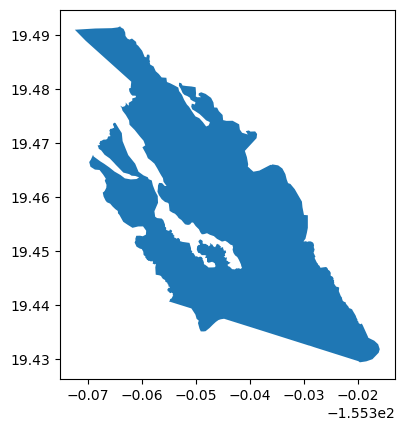

In [11]:
actual_boundary_gdf = gpd.GeoDataFrame.from_features(geojson_boundary['features'])
actual_boundary_gdf.plot()

In [12]:
buffer = .05
approx_bounding_box_geojson = {
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "properties": {},
            "geometry": {
                "type": "Polygon",
                "coordinates": [
                    [
                        [
                            round(actual_boundary_gdf.bounds.minx[0], ndigits=4)
                            - buffer,
                            round(actual_boundary_gdf.bounds.miny[0], ndigits=4)
                            - buffer,
                        ],
                        [
                            round(actual_boundary_gdf.bounds.maxx[0], ndigits=4)
                            + buffer,
                            round(actual_boundary_gdf.bounds.miny[0], ndigits=4)
                            - buffer,
                        ],
                        [
                            round(actual_boundary_gdf.bounds.maxx[0], ndigits=4)
                            + buffer,
                            round(actual_boundary_gdf.bounds.maxy[0], ndigits=4)
                            + buffer,
                        ],
                        [
                            round(actual_boundary_gdf.bounds.minx[0], ndigits=4)
                            - buffer,
                            round(actual_boundary_gdf.bounds.maxy[0], ndigits=4)
                            + buffer,
                        ],
                        [
                            round(actual_boundary_gdf.bounds.minx[0], ndigits=4)
                            - buffer,
                            round(actual_boundary_gdf.bounds.miny[0], ndigits=4)
                            - buffer,
                        ],
                    ],
                ],
            },
        }
    ],
}

approx_bounding_box_gdf = gpd.GeoDataFrame.from_features(approx_bounding_box_geojson['features'])

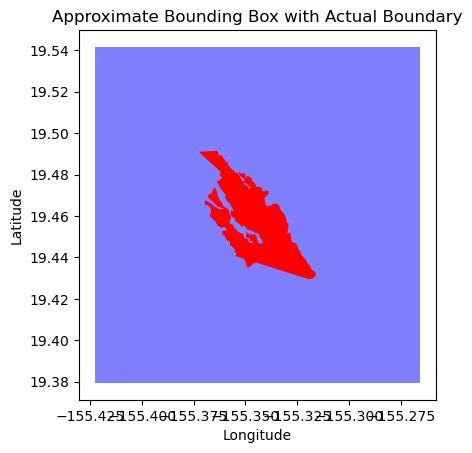

In [13]:
approx_bounding_box_gdf.plot(color='blue', alpha=0.5)
actual_boundary_gdf.plot(ax=plt.gca(), color='red')

plt.title('Approximate Bounding Box with Actual Boundary')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()


In [14]:
# create a Sentinel2Client instance
geo_client = Sentinel2Client(geojson_boundary=approx_bounding_box_geojson, buffer=0.1)

# get imagery data before and after the fire
satellite_pass_information = geo_client.query_fire_event(
    prefire_date_range=["2018-07-21", "2018-08-05"],
    postfire_date_range=["2018-08-17", "2018-08-31"],
    from_bbox=True,
)

# calculate burn metrics
geo_client.calc_burn_metrics()

Initialized Sentinel2Client with bounds: [-155.51999999999998, 19.279999999999998, -155.17000000000002, 19.64]


/opt/conda/envs/burn-severity/lib/python3.10/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(
/opt/conda/envs/burn-severity/lib/python3.10/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(
/opt/conda/envs/burn-severity/lib/python3.10/site-packages/xarray/core/computation.py:825: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


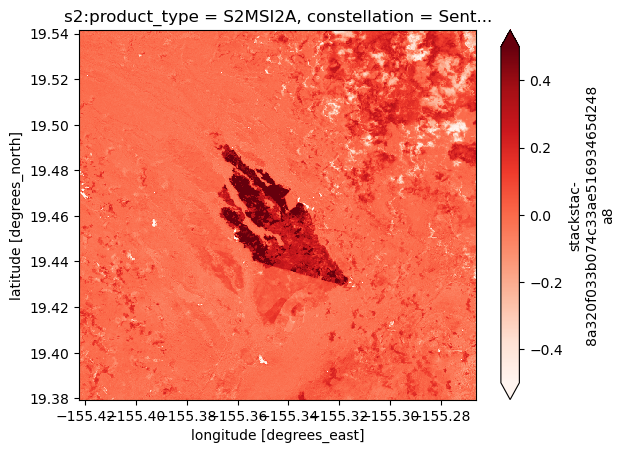

In [17]:
geo_client.metrics_stack.sel(burn_metric="rbr").plot(vmin=-0.5, vmax=0.5, cmap="Reds")

<Axes: >

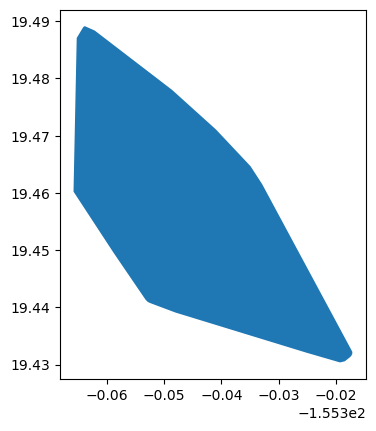

In [18]:
derived_boundary_025 = geo_client.derive_boundary("rbr", 0.25, inplace=False)
gpd.GeoDataFrame.from_features(derived_boundary_025["features"]).plot()

Convex hull is no good anytime the burn area is complex in any way. There are a few ways we could address this:

1. Threshold, but do it better. Essentially we want two classes that look as different from each other as possible. This won't always work, in the case where rapid greenup or senesce occurs that isn't related to the fire, for example, but we can certainly improve on a hardcoded threshold.

2. Use a different segmentation algorithm to find the burn area, based purely on spectral data (or in our case, derived spectral indices)

3. Use external data (like a DEM or some soil / veg information) to help us segment the burn area. This makes _some_ sense since we expect the vegetative communities to drive where the burn area is, however, these data can be unreliable in some cases. Using this, and some labelled data, we could train a model to segment the burn area in a more robust way. Since this requires some labelled data (which we _do_ have from calfire and BAER, but unclear which of these were validated), it would be a bit more complicated.   

For this reason, it would be preferable to avoid exogenous data, for now. Let's try some out of the box segmentation here, from the skimage library.

In [88]:
# Convert our xarray object a numpy array for skimage
rbr_values = geo_client.metrics_stack.sel(burn_metric="rbr").values
rbr_values = np.nan_to_num(rbr_values, nan=0.0)

# set anything above 1 or below -1 to 0
rbr_values[abs(rbr_values) > 1] = 0

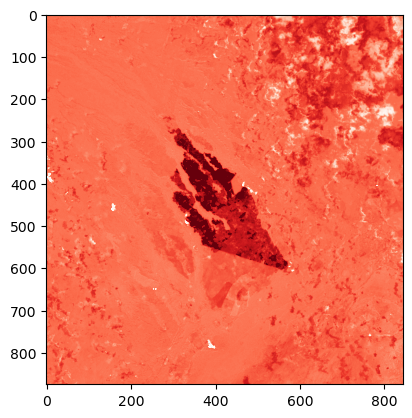

In [34]:
plt.imshow(rbr_values, cmap="Reds", vmin=-0.5, vmax=0.5)

(array([2.00000e+00, 5.00000e+00, 4.00000e+00, 2.00000e+00, 3.00000e+00,
        4.00000e+00, 5.00000e+00, 6.00000e+00, 8.00000e+00, 8.00000e+00,
        7.00000e+00, 3.00000e+00, 7.00000e+00, 3.00000e+00, 8.00000e+00,
        7.00000e+00, 5.00000e+00, 8.00000e+00, 9.00000e+00, 1.40000e+01,
        8.00000e+00, 1.30000e+01, 1.10000e+01, 1.30000e+01, 1.80000e+01,
        2.40000e+01, 4.60000e+01, 6.80000e+01, 1.09000e+02, 1.56000e+02,
        1.85000e+02, 2.31000e+02, 2.71000e+02, 2.95000e+02, 3.49000e+02,
        4.77000e+02, 4.90000e+02, 5.67000e+02, 6.51000e+02, 8.50000e+02,
        1.07400e+03, 1.26700e+03, 1.47600e+03, 1.53800e+03, 1.73700e+03,
        1.99100e+03, 2.32200e+03, 2.88600e+03, 3.61600e+03, 5.29800e+03,
        8.44800e+03, 1.60440e+04, 3.50040e+04, 8.06990e+04, 1.46219e+05,
        1.41022e+05, 7.85460e+04, 4.30710e+04, 2.81030e+04, 1.96640e+04,
        1.49660e+04, 1.20460e+04, 1.10540e+04, 9.77800e+03, 8.38300e+03,
        7.04300e+03, 5.71800e+03, 5.07900e+03, 4.57

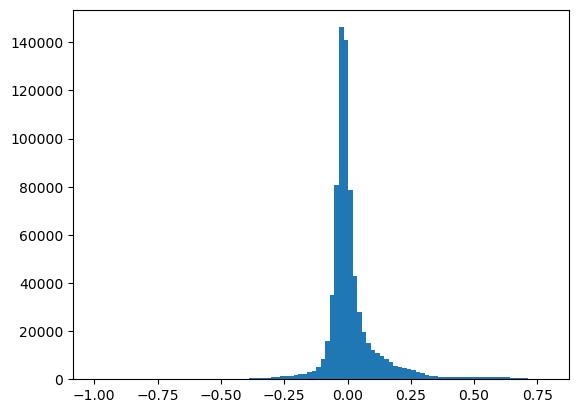

In [92]:
# density plot of rbr values
plt.hist(rbr_values.flatten(), bins=100)

## Better thresholding

In [110]:
from skimage.filters import try_all_threshold

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


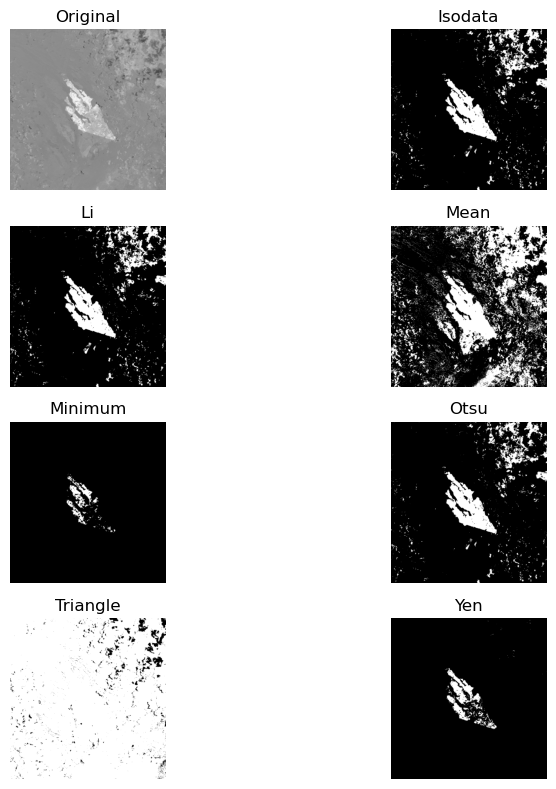

In [113]:
fig, ax = try_all_threshold(
    rbr_values,
    figsize=(10, 8)
)
plt.show()

Pretty good - but we will need to know where the origin of the fire is, to be able to determine where to filter out things that are not connected to that origin. 

## Out of the box skimage segmentation

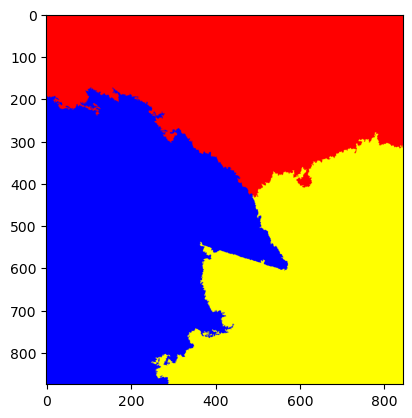

In [108]:
from skimage.segmentation import slic

scar_slic = slic(rbr_values, n_segments=3, compactness = .05, channel_axis=None)
plt.imshow(label2rgb(scar_slic))

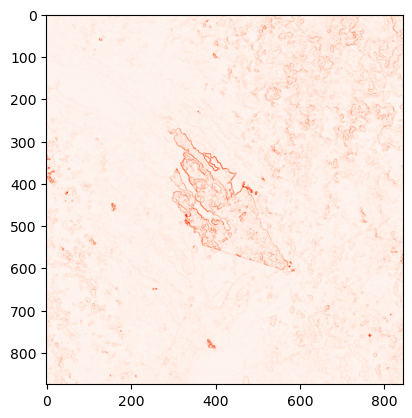

In [169]:
from skimage.filters import sobel
scar_sobel = sobel(rbr_values)
plt.imshow(scar_sobel, cmap="Reds")

Just for fun, let's try SegmentAnything, according to the docs (https://github.com/facebookresearch/segment-anything).

In [170]:
! pip install git+https://github.com/facebookresearch/segment-anything.git
! pip install opencv-python pycocotools matplotlib onnxruntime onnx

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-221ek1yy
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-221ek1yy
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done


In [171]:
from segment_anything import SamPredictor, sam_model_registry
sam = sam_model_registry["vit_h"](checkpoint="sam_vit_h_4b8939.pth")
predictor = SamPredictor(sam)
predictor.set_image(rbr_values)


ModuleNotFoundError: No module named 'torch'

In [ ]:

masks, _, _ = predictor.predict("Burn scar at center of image")